# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [58]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [59]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [60]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-08-22 09:00:00+09:00,42629.808594,42720.570312,42392.460938,42393.210938,0,0.0,0.0
2025-08-22 09:15:00+09:00,42391.191406,42564.039062,42331.390625,42476.308594,0,0.0,0.0
2025-08-22 09:30:00+09:00,42480.988281,42622.660156,42480.988281,42579.871094,0,0.0,0.0
2025-08-22 09:45:00+09:00,42584.441406,42647.648438,42555.761719,42633.578125,0,0.0,0.0
2025-08-22 10:00:00+09:00,42632.878906,42645.371094,42534.238281,42585.378906,0,0.0,0.0
2025-08-22 10:15:00+09:00,42579.871094,42662.429688,42562.871094,42649.199219,0,0.0,0.0
2025-08-22 10:30:00+09:00,42652.441406,42685.011719,42623.628906,42671.601562,0,0.0,0.0
2025-08-22 10:45:00+09:00,42672.398438,42672.398438,42596.050781,42619.828125,0,0.0,0.0
2025-08-22 11:00:00+09:00,42621.308594,42694.398438,42619.441406,42684.089844,0,0.0,0.0


## 前日終値の取得

In [61]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-08-15 00:00:00+09:00    43378.308594
2025-08-18 00:00:00+09:00    43714.308594
2025-08-19 00:00:00+09:00    43546.289062
2025-08-20 00:00:00+09:00    42888.550781
2025-08-21 00:00:00+09:00    42610.171875
2025-08-22 00:00:00+09:00    42686.328125
Name: Close, dtype: float64


Date
2025-08-21 00:00:00+09:00    42610.171875
Name: Close, dtype: float64

## ローソク足チャート（小さいサイズ）

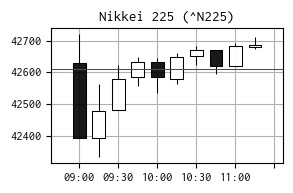

In [62]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()